In [ ]:
# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(
#     cmap='coolwarm', 
#     axis=None, 
#     vmin=-1, 
#     vmax=1
# )  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'

# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

# Imports

In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

import datetime as dt
import pickle
import numpy as np
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
import ray

from data_layer import arrow_dataset, storage_adaptor
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, daily_stats
from workflows import sampler_task, sampler_flow, read_flow
from workflows.configs import renko_v1, renko_v2
from utilities import date_fu, project_globals as g
from data_layer import storage_adaptor, fsspec_factory, data_access, arrow_dataset

In [16]:
config = renko_v2.config

prefix_data = '/data/trades'

prefix_meta = f"/bars/{config['meta']['config_id']}/meta"

prefix_df = f"/bars/{config['meta']['config_id']}/df"

In [19]:
data_access.list_sd_data(prefix=prefix_df, source='remote', show_storage=True)

{'MB': 456.2}

# Read flow

In [ ]:
ds = arrow_dataset.get_dataset(prefix_df, fs_type='s3')

df = ds.to_table().to_pandas()

In [ ]:
df.groupby(['symbol','date']).mean().reset_index().groupby('symbol').mean().describe()

In [ ]:
df.groupby(['symbol','date']).count().reset_index().groupby('symbol').mean().describe()

# Tick Sampler 

In [8]:
ray.init(dashboard_host='0.0.0.0', dashboard_port=1111, ignore_reinit_error=True)

2021-06-05 22:41:27,096	INFO services.py:1267 -- View the Ray dashboard at http://0.0.0.0:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:10616',
 'object_store_address': '/tmp/ray/session_2021-06-05_22-41-24_712577_32499/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-05_22-41-24_712577_32499/sockets/raylet',
 'webui_url': '0.0.0.0:1111',
 'session_dir': '/tmp/ray/session_2021-06-05_22-41-24_712577_32499',
 'metrics_export_port': 58800,
 'node_id': 'd8d99efc4c1dd1cd040ea64ee0726356c202e5770aa8b472f75dd5d8'}

In [ ]:
ray.shutdown()

In [ ]:
bds = sampler_flow.run(config)

2019-01-03


<AxesSubplot:>

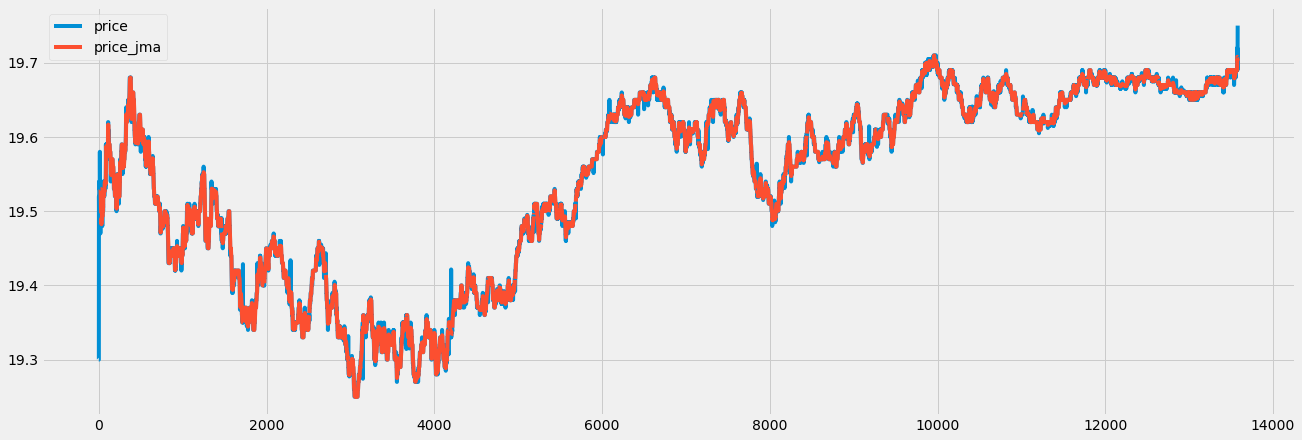

In [20]:
n = 1
print(bds[n]['date'])
# bds[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")
bds[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:>

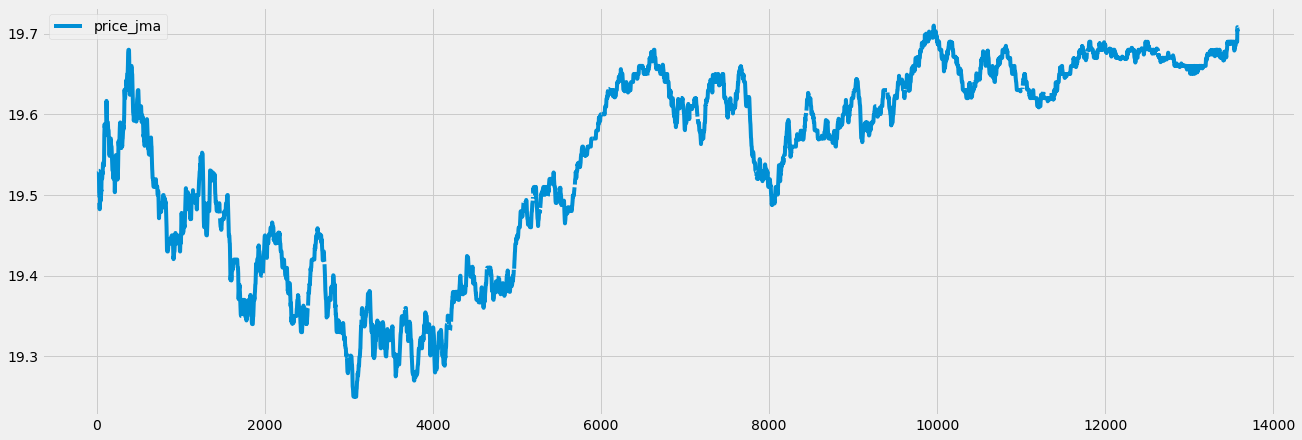

In [21]:
bds[n]['ticks_df'][['price_jma']].plot()

In [22]:
bds[n]['ticks_df'].status.value_counts() / len(bds[n]['ticks_df'])

clean: market-open              0.983136
filtered: irregular condition   0.013771
clean: after-hours              0.001473
filtered: mad_warmup            0.001399
filtered: ts diff               0.000147
filtered: mad_outlier           0.000074
Name: status, dtype: float64

<AxesSubplot:>

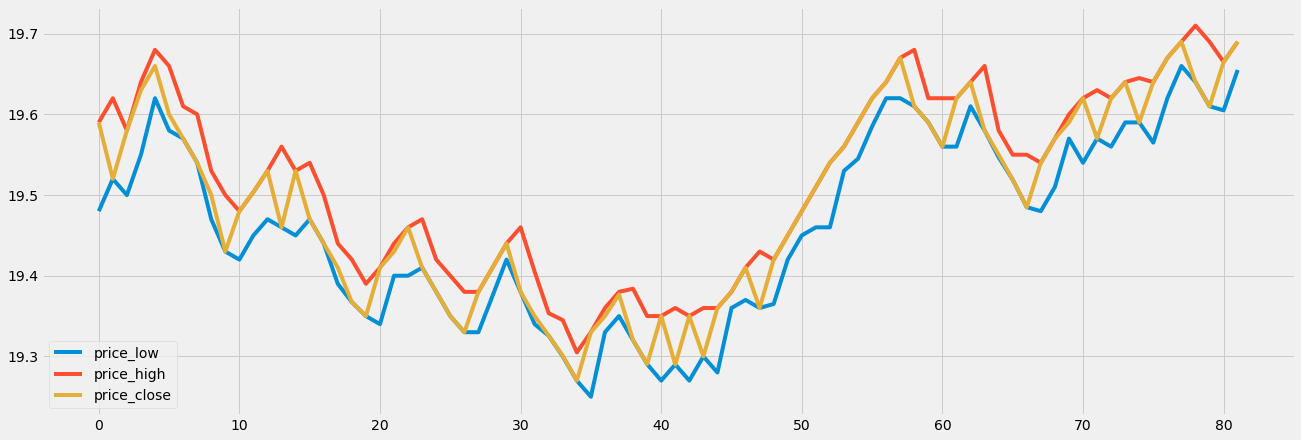

In [23]:
bds[n]['bars_df'][['price_low', 'price_high', 'price_close']].plot()

# Price gap fill

In [ ]:
from sample_features import stacked
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bar_dates, fill_col='price_vwap')

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)


In [ ]:
stats_df.describe()